In [1]:
#this notebook reads the experimental and simulation data from a defined directory
#then a cross-validation protocol on all data is performed using in order to find best regularization type and strength
#ultimately the results published in this study are obtained

In [2]:
import concurrent.futures

In [3]:
def main(regularization_list):
    import scipy
    from scipy.optimize import minimize
    import cudamat as cm
    import numpy as np
    import matplotlib.pyplot as plt
    import re
    import math
    import gc
    kBT=0.6 #kBT in kcal/mol
    np.random.seed(1995)
    
    def activate_cuda(traj,weights, USE_CUDA):

        if USE_CUDA:
            # this is necessary to allow for CUDA operation
            cm.init(max_ones=traj.shape[0])
            cm_traj=cm.CUDAMatrix(traj.T)
            cm_weights=cm.CUDAMatrix(np.reshape(weights,(1,-1)))
            return cm_traj, cm_weights
        else:
            return traj,weights

    def compute_newweights(par,cm_traj,cm_weights,USE_CUDA):

        if USE_CUDA:
            cm_par=cm.CUDAMatrix(np.reshape(par,(1,-1)))
            cm_correction=cm.dot(cm_par,cm_traj)

            m=float(cm_correction.min(axis=1).asarray()[0,0])
            cm_correction.subtract(m)
            cm_correction.mult(-1.0)
            newweights=cm.exp(cm_correction)
            newweights.mult_by_row(cm_weights)
            newweights.mult(1.0/(cm.sum(newweights,axis=1).asarray()[0,0]))
            return newweights 
        else:
            correction=np.matmul(cm_traj,par)
            correction-=np.min(correction)
            newweights=np.exp(-correction)*cm_weights
            return newweights/np.sum(newweights)

    def function(par,obs,newweights,traj,cm_traj,USE_CUDA):

        gradient=True
        if USE_CUDA:
            if(isinstance(obs,cm.CUDAMatrix)):
                cm_obs=obs
            else:
                cm_obs=cm.CUDAMatrix(obs)
            if(isinstance(newweights,cm.CUDAMatrix)):
                cm_newweights=newweights
            else:
                cm_newweights=cm.CUDAMatrix(np.reshape(newweights,(1,-1)))
            av_obs=np.reshape(np.array(cm.dot(cm_newweights,cm_obs).asarray()),(-1))
        else:
            av_obs=np.reshape(np.array(np.matmul(newweights,obs)),(-1))

        if not gradient:
            return av_obs

        dav=np.zeros((len(par),obs.shape[1]))

        if USE_CUDA:
            cm_traj_weighted=cm.empty((traj.shape[1],traj.shape[0]))
            cm_traj_weighted.assign(cm_traj)
            cm_traj_weighted.mult_by_row(cm_newweights)
            av_traj=np.reshape(cm_traj_weighted.sum(axis=1).asarray(),(-1))
            dav=-cm.dot(cm_traj_weighted,cm_obs).asarray()
        else:
            weighted_traj=np.copy(traj)
            for ipar in range(len(par)):
                weighted_traj[:,ipar]=newweights*traj[:,ipar]
            av_traj=np.matmul(newweights,traj)
            for ipar in range(len(par)):
                for iobs in range(obs.shape[1]):
                    dav[ipar,iobs]=-np.sum(weighted_traj[:,ipar]*obs.T[iobs,:])

        for ipar in range(len(par)):
            for iobs in range(obs.shape[1]):
                dav[ipar,iobs]+=av_obs[iobs]*av_traj[ipar]

        return av_obs,dav
    
    def _logsum(ns):
        max = np.max(ns)
        ds = ns - max
        sumOfExp = np.exp(ds).sum()
        return max + np.log(sumOfExp)
    
    def _softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    def func_and_grad(par,gradient=True,regularize=True,components=False):
        func=0.0
        chi2_native_GAGA=0.0
        chi2_native_UUCG=0.0
        chi2_noe=0.0
        chi2_unoe=0.0
        chi2_backbone1=0.0
        chi2_backbone2=0.0
        chi2_sugar=0.0

        if gradient:
            grad=np.zeros(len(par))
            grad_backbone1=np.zeros(len(par))
            grad_backbone2=np.zeros(len(par))
            grad_sugar=np.zeros(len(par))
            grad_noe=np.zeros(len(par))
            grad_unoe=np.zeros(len(par))
            grad_native_GAGA=np.zeros(len(par))
            grad_native_UUCG=np.zeros(len(par))



        USE_CUDA=True
        TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])

        funcGAGA=0.0
        gradGAGA=np.zeros(len(par))
        if obs_weight[0] != 0:
            chi2_native_GAGA=0.0
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationGAGA,w, trajGAGA,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_GAGA+=diff**2
                    if gradient:
                        grad_native_GAGA+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcGAGA=obs_weight[0]*TLweight*chi2_native_GAGA
            if gradient:
                gradGAGA=obs_weight[0]*TLweight*grad_native_GAGA



        funcUUCG=0.0
        gradUUCG=np.zeros(len(par))
        if obs_weight[1] != 0:
            chi2_native_UUCG=0.0
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

            f=function(par,populationUUCG,w, trajUUCG,cm_traj, USE_CUDA)
            target_population=0.5
            diff=np.log(f[0]+eps)-np.log(target_population) 
            if(diff<.0):
                    chi2_native_UUCG+=diff**2
                    if gradient:
                        grad_native_UUCG+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
            funcUUCG=obs_weight[1]*TLweight*chi2_native_UUCG
            if gradient:
                gradUUCG=obs_weight[1]*TLweight*grad_native_UUCG

        func+=prefactor*(funcGAGA+funcUUCG)
        if gradient:
            grad+=prefactor*(gradGAGA+gradUUCG)

        USE_CUDA=True
        cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

        if obs_weight[2] != 0:
            f=function(par,noe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_noe=np.sum(((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1])**2)/noe_exp.shape[0]
            func+=obs_weight[2]*noe_exp.shape[0]*chi2_noe
            if gradient:
                grad_noe+=np.matmul(f[1],(2/noe_exp.shape[0] * ((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1]) * (-1/6) * f[0]**(-7/6))/noe_exp[:,1])
                grad+=obs_weight[2]*noe_exp.shape[0]*grad_noe

        if obs_weight[3] != 0:
            f=function(par,unoe,w, trajGACC,cm_traj, USE_CUDA)
            chi2_unoe=0.0
            for i in range(len(f[0])):
                diff=f[0][i]**(-1/6)-unoe_exp[i,0]
                if(diff<.0):
                    chi2_unoe+=(diff/unoe_exp[i,1])**2/unoe_exp.shape[0]
                    if gradient:
                        grad_unoe+=f[1][:,i]*2/unoe_exp.shape[0]* diff/unoe_exp[i,1]* (-1/6) * f[0][i]**(-7/6) /unoe_exp[i,1]
            func+=obs_weight[3]*unoe_exp.shape[0]*chi2_unoe
            if gradient:
                grad+=obs_weight[3]*unoe_exp.shape[0]*grad_unoe

        if obs_weight[4] != 0:
            f=function(par,backbone1,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone1=np.sum(((f[0]-backbone1_exp[:,0])/backbone1_exp[:,1])**2)/backbone1_exp.shape[0]
            func+=obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1
            if gradient:
                grad_backbone1+=np.matmul(f[1],2/backbone1_exp.shape[0] * (f[0]-backbone1_exp[:,0])/backbone1_exp[:,1]/backbone1_exp[:,1])
                grad+=obs_weight[4]*backbone1_exp.shape[0]*grad_backbone1

        if obs_weight[5] != 0:
            f=function(par,backbone2,w, trajGACC,cm_traj, USE_CUDA)
            chi2_backbone2=np.sum(((f[0]-backbone2_exp[:,0])/backbone2_exp[:,1])**2)/backbone2_exp.shape[0]
            func+=obs_weight[5]*backbone2_exp.shape[0]*chi2_backbone2
            if gradient:
                grad_backbone2+=np.matmul(f[1],2/backbone2_exp.shape[0] * (f[0]-backbone2_exp[:,0])/backbone2_exp[:,1]/backbone2_exp[:,1])
                grad+=obs_weight[5]*backbone2_exp.shape[0]*grad_backbone2

        if obs_weight[6] != 0:
            f=function(par,sugar,w, trajGACC,cm_traj, USE_CUDA)
            chi2_sugar=np.sum(((f[0]-sugar_exp[:,0])/sugar_exp[:,1])**2)/sugar_exp.shape[0]
            func+=obs_weight[6]*sugar_exp.shape[0]*chi2_sugar
            if gradient:
                grad_sugar+=np.matmul(f[1],2/sugar_exp.shape[0] * (f[0]-sugar_exp[:,0])/sugar_exp[:,1]/sugar_exp[:,1])
                grad+=obs_weight[6]*sugar_exp.shape[0]*grad_sugar

        denominator=(obs_weight[0]*TLweight+obs_weight[1]*TLweight+obs_weight[2]*noe_exp.shape[0]+obs_weight[3]*unoe_exp.shape[0] + obs_weight[4]*backbone1_exp.shape[0]+ obs_weight[5]*backbone2_exp.shape[0]+obs_weight[6]*sugar_exp.shape[0])
        func/=denominator


        if gradient:
            grad/=denominator

        if regularize:
            if regularization == 'L1':
                regL1=alpha * np.sum(np.sqrt(eps+par**2))
                func+=regL1
                if gradient:
                    grad_regL1=(alpha*par)/(np.sqrt(eps+par**2))
                    grad+=grad_regL1


            if regularization == 'L2':
                regL2=alpha * np.sum(par**2)
                func+=regL2
                if gradient:
                    grad_regL2=2*alpha*par
                    grad+=grad_regL2

            if regularization == 'KishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]


                kish=np.sum((new_weights[0]**2))
                kish_GAGA=np.sum((new_weights[1]**2))
                kish_UUCG=np.sum((new_weights[2]**2))

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))
                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem**2)
                        c_a_i=t[index]
                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=-2*alpha*np.matmul(w_i,(c_a_i - c_ave)) 
                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeKishSize':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                Nf_list=[len(trajGACC),len(trajGAGA),len(trajUUCG)]
                kish=np.sum((eps+(new_weights[0]**2))/(eps+w_list[0]))/Nf_list[0]
                kish_GAGA=np.sum((eps+(new_weights[1]**2))/(eps+w_list[1]))/Nf_list[1]
                kish_UUCG=np.sum((eps+(new_weights[2]**2))/(eps+w_list[2]))/Nf_list[2]

                kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))

                chi2_kish=alpha*kish_size
                func+=chi2_kish

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=eps+(elem**2)
                        w_i/=(eps+w_list[index])
                        c_a_i=t[index]

                        c_ave=np.matmul(new_weights[index],c_a_i)
                        grad_array[index]=np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=-(2*alpha)
                        grad_array[index]/=Nf_list[index]

                        grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

            if regularization == 'RelativeEntropy':
                USE_CUDA=True
                cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
                wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
                wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
                wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
                t=[trajGACC, trajGAGA, trajUUCG] 
                w_list=[weightsGACC, weightsGAGA, weightsUUCG]
                new_weights=[wGACC,wGAGA,wUUCG]

                entropy=np.exp(np.sum(new_weights[0]*np.log((new_weights[0])/(w_list[0])+eps)))
                entropy_GAGA=np.exp(np.sum(new_weights[1]*np.log((new_weights[1])/(w_list[1])+eps)))
                entropy_UUCG=np.exp(np.sum(new_weights[2]*np.log((new_weights[2])/(w_list[2])+eps)))

                relative_entropy=_logsum(np.array([entropy,entropy_GAGA,entropy_UUCG]))

                chi2_entropy=alpha*relative_entropy
                func+=chi2_entropy

                if gradient:
                    grad_array=[0.0,0.0,0.0]

                    for index,elem in enumerate(new_weights):
                        w_i=(elem) 
                        w_i_0=w_list[index]
                        c_a_i=t[index]
                        c_ave=np.matmul(eps+new_weights[index],c_a_i)
                        grad_array[index]=np.array([entropy,entropy_GAGA,entropy_UUCG])[index]

                        part1=-np.matmul(w_i*np.log((w_i/w_i_0)+eps),(c_a_i - c_ave))
                        part2=alpha*part1-alpha*np.matmul(w_i,(c_a_i - c_ave))
                        grad_array[index]*=part2

                        grad_array[index]*=_softmax(np.array([entropy,entropy_GAGA,entropy_UUCG]))[index]

                    grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)


        if gradient:
            return float(func), np.array(grad)        

        if components:
            chi2_native_GAGA=float(obs_weight[0]*TLweight*chi2_native_GAGA)
            chi2_native_UUCG=float(obs_weight[1]*TLweight*chi2_native_UUCG)
            chi2_noe=float(obs_weight[2]*noe_exp.shape[0]*chi2_noe)
            chi2_unoe=float(obs_weight[3]*unoe_exp.shape[0]*chi2_unoe)
            chi2_backbone1=float(obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1)
            chi2_backbone2=float(obs_weight[4]*backbone2_exp.shape[0]*chi2_backbone2)
            chi2_sugar=float(obs_weight[5]*sugar_exp.shape[0]*chi2_sugar)

            return float(func), chi2_backbone1/denominator,chi2_backbone2/denominator,chi2_sugar/denominator,chi2_noe/denominator,chi2_unoe/denominator, chi2_native_GAGA/denominator,chi2_native_UUCG/denominator  

        return float(func)
    
    def save(data):
        alpha_list=data[0]
        mini=str(min(alpha_list)).replace('.', '')
        maxi=str(max(alpha_list)).replace('.', '')
        #Training and CV error
        Training_error_list=np.array(data[2][::-1])
        Training_error_std_list=np.array(data[3][::-1])
        CV_error_list=np.array(data[11][::-1])
        CV_error_std_list=np.array(data[12][::-1])
        reference_error=np.array(data[20][::-1])
        Training_reference_error=np.array(data[21][::-1])
        CV_reference_error=np.array(data[22][::-1])

        with open("./data_produced/CVTrajectory_indivComp_errors_%s_%s_%sto%s.dat" %(regularization,eps,mini,maxi), 'w')as f:
            for index,elem in enumerate(CV_error_list):
                f.write(str(alpha_list[index]) + ' ' + str(Training_error_list[index])+ ' ' + str(Training_error_std_list[index])+ ' ' + str(CV_error_list[index]) + ' ' + str(CV_error_std_list[index])+ ' ' + str(reference_error[index])+ ' ' + str(Training_reference_error[index])+ ' ' + str(CV_reference_error[index]) + ' ' + '\n')

        #chi2 components Training
        chi2_native_GAGA=np.array(data[4][::-1])
        chi2_native_UUCG=np.array(data[5][::-1])
        chi2_noes=np.array(data[6][::-1])
        chi2_unoes=np.array(data[7][::-1])
        chi2_sugar=np.array(data[8][::-1])
        chi2_backbone1=np.array(data[9][::-1])
        chi2_backbone2=np.array(data[10][::-1])
        with open("./data_produced/CVTrajectory_indivComp_chi2Components_Training_%s_%s_%sto%s.dat" %(regularization,eps,mini,maxi), 'w')as f: 
            for index,elem in enumerate(Training_error_list):
                    f.write(str(alpha_list[index]) + ' ' + str(chi2_native_GAGA[index])+ ' ' + str(chi2_native_UUCG[index])+ ' ' + str(chi2_noes[index]) + ' ' + str(chi2_unoes[index])+ ' ' + str(chi2_sugar[index]) + ' ' + str(chi2_backbone1[index])+ ' ' + str(chi2_backbone2[index]) + '\n')

        #chi2 components CV
        chi2_native_GAGA=np.array(data[13][::-1])
        chi2_native_UUCG=np.array(data[14][::-1])
        chi2_noes=np.array(data[15][::-1])
        chi2_unoes=np.array(data[16][::-1])
        chi2_sugar=np.array(data[17][::-1])
        chi2_backbone1=np.array(data[18][::-1])
        chi2_backbone2=np.array(data[19][::-1])
        with open("./data_produced/CVTrajectory_indivComp_chi2Components_CV_%s_%s_%sto%s.dat" %(regularization,eps,mini,maxi), 'w')as f:
            for index,elem in enumerate(CV_error_list):
                    f.write(str(alpha_list[index]) + ' ' + str(chi2_native_GAGA[index])+ ' ' + str(chi2_native_UUCG[index])+ ' ' + str(chi2_noes[index]) + ' ' + str(chi2_unoes[index])+ ' ' + str(chi2_sugar[index]) + ' ' + str(chi2_backbone1[index])+ ' ' + str(chi2_backbone2[index]) + '\n')


        lambdas = np.asarray(data[1])
        np.savetxt("./data_produced/CVTrajectory_indivComp_Lambdas_%s_%s_%sto%s.dat" %(regularization,eps,mini,maxi), lambdas, delimiter=',')
        
    
    def weighted_avg_and_std(values, weights):
        average = np.average(values, weights=weights)
        variance = np.average((values-average)**2, weights=weights)
        return (average, math.sqrt(variance))
    
    trajectoryNamesGACC=[]
    trajectoryNamesGAGA=[]
    trajectoryNamesUUCG=[]
    FFprefactorsGACC=[]
    FFprefactorsGAGA=[]
    FFprefactorsUUCG=[]

    with open("./data_loaded/coefficients.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            l=line.split()
            file=l[0]+".skip.npy"
            trajectoryNamesGACC.append(file)
            FFprefactorsGACC.append(np.array(np.array(l)[1:],dtype='float'))

    with open("./data_loaded/coefficients_TLs.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            if line.strip():
                l=line.split()
                file=l[0]+".npy"
                if 'gaga' in line:
                    FFprefactorsGAGA.append(np.array(l[1:],dtype='float'))
                if 'uucg' in line:
                    FFprefactorsUUCG.append(np.array(l[1:],dtype='float'))
        
    def wham(bias_ff,frame_weight=None,traj_weight=None,T=1.0,maxit=1000,threshold=1e-40,verbose=False):
        """WHAM tool

           bias_ff[i,j] is the potential applied on frame i by Hamiltonian j
           Returns an array with the weight of each frame

        """
        import numpy as np
        # allow lists
        if not isinstance(bias_ff, (np.ndarray, np.generic) ):
            bias_ff=np.array(bias_ff)

        nframes=bias_ff.shape[0]
        ntraj=bias_ff.shape[1]

        # default values
        if frame_weight is None:
            frame_weight=np.ones(nframes)
        if traj_weight is None:
            traj_weight=np.ones(ntraj)

        assert(len(traj_weight)==ntraj)
        assert(len(frame_weight)==nframes)

        # do exponentials only once
        expv=np.exp((-bias_ff+np.min(bias_ff))/T)

        Z=np.ones(ntraj)
        Zold=np.copy(Z)

        if(verbose):
            print("WHAM: start")
        for it in range(maxit):
            weight=1.0/np.matmul(expv,traj_weight/Z)
            weight/=np.sum(weight*frame_weight)
            Z=np.matmul(frame_weight*weight,expv)
            Z/=np.sum(Z*traj_weight)
            eps=np.sum(np.log(Z/Zold)**2)
            Zold=Z
            if verbose:
                print("WHAM: iteration",it,"eps",eps)
            if(eps<threshold):
                break
        if(verbose):
            print("WHAM: end")
        return weight*frame_weight
    
    print("Load experimental data")
    noe_exp=np.loadtxt("./data_loaded/GACC/exp_noes",usecols=(2,3))
    unoe_exp=np.loadtxt("./data_loaded/GACC/exp_unobs-noes",usecols=(2,3))
    sugar_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-sugar",usecols=(1,2))
    backbone1_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-1",usecols=(1,2))
    backbone2_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-2",usecols=(1,2))
    print(noe_exp.shape)
    print(unoe_exp.shape)
    print(sugar_exp.shape)
    print(backbone1_exp.shape)
    print(backbone2_exp.shape)
    print('There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.')
    
    bounds=[]
    for i in range(12):
        bounds.append((-1.666666666666666,+1.666666666666666)) #bonds in kbT units set to -1 to 1 in kcal/mol (kbT*0.6=kcal/mol)

    eps=1e-30

    nblocks=5 #define the number of blocks to split the trajectories into

    prefactor=1.0
    TLweight=(noe_exp.shape[0]+unoe_exp.shape[0]+sugar_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0])

    #load simulation data
    training_index=[0,1,2,3,4]
    trajGACC=np.load("./data_loaded/trajGACC_blocks.npy")[training_index].reshape(-1,12)
    weightsGACC=wham(np.matmul(trajGACC,np.transpose(FFprefactorsGACC-FFprefactorsGAGA[1])),verbose=False,threshold=1e-20,T=kBT)
    noe=np.load("./data_loaded/noe_blocks.npy")[training_index].reshape(-1,20)
    unoe=np.load("./data_loaded/unoe_blocks.npy")[training_index].reshape(-1,285)
    backbone1=np.load("./data_loaded/backbone1_blocks.npy")[training_index].reshape(-1,8)
    backbone2=np.load("./data_loaded/backbone2_blocks.npy")[training_index].reshape(-1,9)
    sugar=np.load("./data_loaded/sugar_blocks.npy")[training_index].reshape(-1,12)
    trajGAGA=np.load("./data_loaded/trajGAGA_blocks.npy")[training_index].reshape(-1,12)
    biasGAGA=np.load("./data_loaded/biasGAGA_blocks.npy")[training_index].reshape(-1,2)
    weightsGAGA=wham(biasGAGA,verbose=False,threshold=1e-20,T=kBT)
    populationGAGA=np.load("./data_loaded/populationGAGA_blocks.npy")[training_index].reshape(-1,1)
    trajUUCG=np.load("./data_loaded/trajUUCG_blocks.npy")[training_index].reshape(-1,12)
    biasUUCG=np.load("./data_loaded/biasUUCG_blocks.npy")[training_index].reshape(-1,2)
    weightsUUCG=wham(biasUUCG,verbose=False,threshold=1e-20,T=kBT)
    populationUUCG=np.load("./data_loaded/populationUUCG_blocks.npy")[training_index].reshape(-1,1)
    
    obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
    alpha=0.0
    regularization='None'
    ref_chi2=func_and_grad(np.zeros(12),gradient=False,regularize=False,components=False)
    
    print(ref_chi2)
    
    for regularization in regularization_list:
        if regularization=='L1' or regularization=='L2':
            alpha_list = np.geomspace(10**-3, 10**4, num=199) 
            alpha_list = np.insert(alpha_list, len(alpha_list), 10**7, axis=0)
            alpha_list = np.insert(alpha_list, 0, 0.0, axis=0)
        else:
            alpha_list = np.geomspace(10**-3, 10**7, num=200) 
            alpha_list = np.insert(alpha_list, 0, 0.0, axis=0)

        print(regularization)

        start_lambdas=[]
        collection=[]


        Training_error_list=[]
        Training_error_std_list=[]
        Training_chi2_native_GAGA_mean=[]
        Training_chi2_native_UUCG_mean=[]
        Training_chi2_noes_mean=[]
        Training_chi2_unoes_mean=[]
        Training_chi2_sugar_mean=[]
        Training_chi2_backbone1_mean=[]
        Training_chi2_backbone2_mean=[]

        CV_error_list=[]
        CV_error_std_list=[]
        CV_chi2_native_GAGA_mean=[]
        CV_chi2_native_UUCG_mean=[]
        CV_chi2_noes_mean=[]
        CV_chi2_unoes_mean=[]
        CV_chi2_sugar_mean=[]
        CV_chi2_backbone1_mean=[]
        CV_chi2_backbone2_mean=[]

        reference_error=[]
        Training_ref_chi2_mean=[]
        CV_ref_chi2_mean=[]


        for alpha in reversed(alpha_list):
                print(alpha)
                if not alpha < alpha_list[-1]:
                        for k in range(nblocks):
                            start_lambdas.append(np.zeros(12)) 

                Training_error=[]
                Training_chi2_native_GAGA=[]
                Training_chi2_native_UUCG=[]
                Training_chi2_noes=[]
                Training_chi2_unoes=[]
                Training_chi2_sugar=[]
                Training_chi2_backbone1=[]
                Training_chi2_backbone2=[]

                CV_error=[]
                CV_chi2_native_GAGA=[]
                CV_chi2_native_UUCG=[]
                CV_chi2_noes=[]
                CV_chi2_unoes=[]
                CV_chi2_sugar=[]
                CV_chi2_backbone1=[]
                CV_chi2_backbone2=[]

                Training_ref_chi2=[]
                CV_ref_chi2=[]

                for k in range(nblocks):
                    training_index=[]
                    for i in range(nblocks):
                        if i!=k:
                            training_index.append(i)

                    trajGACC=np.load("./data_loaded/trajGACC_blocks.npy")[training_index].reshape(-1,12)
                    weightsGACC=wham(np.matmul(trajGACC,np.transpose(FFprefactorsGACC-FFprefactorsGAGA[1])),verbose=False,threshold=1e-20,T=kBT)
                    noe=np.load("./data_loaded/noe_blocks.npy")[training_index].reshape(-1,20)
                    unoe=np.load("./data_loaded/unoe_blocks.npy")[training_index].reshape(-1,285)
                    backbone1=np.load("./data_loaded/backbone1_blocks.npy")[training_index].reshape(-1,8)
                    backbone2=np.load("./data_loaded/backbone2_blocks.npy")[training_index].reshape(-1,9)
                    sugar=np.load("./data_loaded/sugar_blocks.npy")[training_index].reshape(-1,12)
                    trajGAGA=np.load("./data_loaded/trajGAGA_blocks.npy")[training_index].reshape(-1,12)
                    biasGAGA=np.load("./data_loaded/biasGAGA_blocks.npy")[training_index].reshape(-1,2)
                    weightsGAGA=wham(biasGAGA,verbose=False,threshold=1e-20,T=kBT)
                    populationGAGA=np.load("./data_loaded/populationGAGA_blocks.npy")[training_index].reshape(-1,1)
                    trajUUCG=np.load("./data_loaded/trajUUCG_blocks.npy")[training_index].reshape(-1,12)
                    biasUUCG=np.load("./data_loaded/biasUUCG_blocks.npy")[training_index].reshape(-1,2)
                    weightsUUCG=wham(biasUUCG,verbose=False,threshold=1e-20,T=kBT)
                    populationUUCG=np.load("./data_loaded/populationUUCG_blocks.npy")[training_index].reshape(-1,1)
                    
                    m=minimize(func_and_grad,x0=start_lambdas[k],method='L-BFGS-B', jac=True)#, bounds=bounds)
                    
                    start_lambdas[k]=m.x


                    collection.append(m.x)

                    #reference
                    Training_ref_chi2.append(func_and_grad(np.zeros(12),gradient=False,regularize=False,components=False))
                    
                    t_chi2,t_chi2_backbone1,  t_chi2_backbone2,  t_chi2_sugar, t_chi2_noes,  t_chi2_unoes, t_chi2_native_GAGA,t_chi2_native_UUCG =func_and_grad(m.x,gradient=False,regularize=False,components=True)
                    Training_error.append(t_chi2)
                    Training_chi2_native_GAGA.append(t_chi2_native_GAGA)
                    Training_chi2_native_UUCG.append(t_chi2_native_UUCG)
                    Training_chi2_noes.append(t_chi2_noes)
                    Training_chi2_unoes.append(t_chi2_unoes)
                    Training_chi2_sugar.append(t_chi2_sugar)
                    Training_chi2_backbone1.append(t_chi2_backbone1)
                    Training_chi2_backbone2.append(t_chi2_backbone2)
                    
                    del trajGACC
                    del weightsGACC
                    del noe
                    del unoe
                    del backbone1
                    del backbone2
                    del sugar
                    del trajGAGA
                    del biasGAGA
                    del weightsGAGA
                    del populationGAGA
                    del trajUUCG
                    del biasUUCG
                    del weightsUUCG
                    del populationUUCG
                        
                    gc.collect()
                    
                    trajGACC=np.load("./data_loaded/trajGACC_blocks.npy")[k].reshape(-1,12)
                    weightsGACC=wham(np.matmul(trajGACC,np.transpose(FFprefactorsGACC-FFprefactorsGAGA[1])),verbose=False,threshold=1e-20,T=kBT)
                    noe=np.load("./data_loaded/noe_blocks.npy")[k].reshape(-1,20)
                    unoe=np.load("./data_loaded/unoe_blocks.npy")[k].reshape(-1,285)
                    backbone1=np.load("./data_loaded/backbone1_blocks.npy")[k].reshape(-1,8)
                    backbone2=np.load("./data_loaded/backbone2_blocks.npy")[k].reshape(-1,9)
                    sugar=np.load("./data_loaded/sugar_blocks.npy")[k].reshape(-1,12)
                    trajGAGA=np.load("./data_loaded/trajGAGA_blocks.npy")[k].reshape(-1,12)
                    biasGAGA=np.load("./data_loaded/biasGAGA_blocks.npy")[k].reshape(-1,2)
                    weightsGAGA=wham(biasGAGA,verbose=False,threshold=1e-20,T=kBT)
                    populationGAGA=np.load("./data_loaded/populationGAGA_blocks.npy")[k].reshape(-1,1)
                    trajUUCG=np.load("./data_loaded/trajUUCG_blocks.npy")[k].reshape(-1,12)
                    biasUUCG=np.load("./data_loaded/biasUUCG_blocks.npy")[k].reshape(-1,2)
                    weightsUUCG=wham(biasUUCG,verbose=False,threshold=1e-20,T=kBT)
                    populationUUCG=np.load("./data_loaded/populationUUCG_blocks.npy")[k].reshape(-1,1)
                    
                    CV_ref_chi2.append(func_and_grad(np.zeros(12),gradient=False,regularize=False,components=False))
                    
                    cv_chi2,    cv_chi2_backbone1,  cv_chi2_backbone2, cv_chi2_sugar,cv_chi2_noes,  cv_chi2_unoes,cv_chi2_native_GAGA,cv_chi2_native_UUCG=func_and_grad(m.x,gradient=False,regularize=False,components=True)
                    
                    CV_error.append(cv_chi2)
                    CV_chi2_native_GAGA.append(cv_chi2_native_GAGA)
                    CV_chi2_native_UUCG.append(cv_chi2_native_UUCG)
                    CV_chi2_noes.append(cv_chi2_noes)
                    CV_chi2_unoes.append(cv_chi2_unoes)
                    CV_chi2_sugar.append(cv_chi2_sugar)
                    CV_chi2_backbone1.append(cv_chi2_backbone1)
                    CV_chi2_backbone2.append(cv_chi2_backbone2)
                    
                    del trajGACC
                    del weightsGACC
                    del noe
                    del unoe
                    del backbone1
                    del backbone2
                    del sugar
                    del trajGAGA
                    del biasGAGA
                    del weightsGAGA
                    del populationGAGA
                    del trajUUCG
                    del biasUUCG
                    del weightsUUCG
                    del populationUUCG
                    
                    gc.collect()
                    
                mean,std=weighted_avg_and_std(np.array(Training_error).reshape(-1,),np.ones(len(Training_error)))    
                Training_error_list.append(mean) 
                Training_error_std_list.append(std)

                Training_ref_chi2

                mean,std=weighted_avg_and_std(np.array(Training_ref_chi2),np.ones(len(Training_ref_chi2)))  
                Training_ref_chi2_mean.append(mean)

                mean,std=weighted_avg_and_std(np.array(Training_chi2_native_GAGA),np.ones(len(Training_chi2_native_GAGA)))  
                Training_chi2_native_GAGA_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(Training_chi2_native_UUCG),np.ones(len(Training_chi2_native_UUCG)))  
                Training_chi2_native_UUCG_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(Training_chi2_noes),np.ones(len(Training_chi2_noes)))  
                Training_chi2_noes_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(Training_chi2_unoes),np.ones(len(Training_chi2_unoes)))  
                Training_chi2_unoes_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(Training_chi2_sugar),np.ones(len(Training_chi2_sugar)))  
                Training_chi2_sugar_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(Training_chi2_backbone1),np.ones(len(Training_chi2_backbone1)))  
                Training_chi2_backbone1_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(Training_chi2_backbone2),np.ones(len(Training_chi2_backbone2)))  
                Training_chi2_backbone2_mean.append(mean)

                mean,std=weighted_avg_and_std(np.array(CV_error).reshape(-1,),np.ones(len(CV_error)))    
                CV_error_list.append(mean) 
                CV_error_std_list.append(std)

                mean,std=weighted_avg_and_std(np.array(CV_ref_chi2),np.ones(len(CV_ref_chi2)))  
                CV_ref_chi2_mean.append(mean)

                mean,std=weighted_avg_and_std(np.array(CV_chi2_native_GAGA),np.ones(len(CV_chi2_native_GAGA)))
                CV_chi2_native_GAGA_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(CV_chi2_native_UUCG),np.ones(len(CV_chi2_native_UUCG)))
                CV_chi2_native_UUCG_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(CV_chi2_noes),np.ones(len(CV_chi2_noes)))
                CV_chi2_noes_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(CV_chi2_unoes),np.ones(len(CV_chi2_unoes)))
                CV_chi2_unoes_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(CV_chi2_sugar),np.ones(len(CV_chi2_sugar)))
                CV_chi2_sugar_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(CV_chi2_backbone1),np.ones(len(CV_chi2_backbone1)))
                CV_chi2_backbone1_mean.append(mean)
                mean,std=weighted_avg_and_std(np.array(CV_chi2_backbone2),np.ones(len(CV_chi2_backbone2)))
                CV_chi2_backbone2_mean.append(mean)

                reference_error.append(ref_chi2)

        list_of_saves=np.array([alpha_list,
        collection,
        Training_error_list,
        Training_error_std_list,
        Training_chi2_native_GAGA_mean,
        Training_chi2_native_UUCG_mean,
        Training_chi2_noes_mean,
        Training_chi2_unoes_mean,
        Training_chi2_sugar_mean,
        Training_chi2_backbone1_mean,
        Training_chi2_backbone2_mean,
        CV_error_list,
        CV_error_std_list,
        CV_chi2_native_GAGA_mean,
        CV_chi2_native_UUCG_mean,
        CV_chi2_noes_mean,
        CV_chi2_unoes_mean,
        CV_chi2_sugar_mean,
        CV_chi2_backbone1_mean,
        CV_chi2_backbone2_mean,
        reference_error,
        Training_ref_chi2_mean,
        CV_ref_chi2_mean])
        save(list_of_saves)
        print('Cross validation on observables complete, data were saved.')

In [5]:
executor=concurrent.futures.ProcessPoolExecutor(max_workers=5)

In [6]:
futureL1 = executor.submit(main,['L1'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
21.803205490112305
L1
10000000.0


In [14]:
print(futureL1)

<Future at 0x7f684eba7fd0 state=running>


In [12]:
futureL2 = executor.submit(main,['L2'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
L2
10000000.0
10000.0
9218.207178777464
8497.534359086438
7833.203223083877
7220.8090183854565
6656.291352986187
6135.907273413163
5656.20644760902
5214.008287999684
4806.380863064389
4430.621457583878
4084.238652674517


In [13]:
print(futureL2)

<Future at 0x7f57ae433fd0 state=running>


In [6]:
futureKishSize = executor.submit(main,['KishSize'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
21.803205490112305
KishSize
10000000.0
8907354.638610458
7934096.665797492
7067181.273927506
6294988.990221888
5607169.938205469
4994505.11585514
4448782.831127594
3962688.638701478
3529707.302730657
3144035.4715915
2800503.8941836366
2494508.135230317


In [7]:
print(futureKishSize)

<Future at 0x7fb660128430 state=running>


In [11]:
futureRelativeKishSize = executor.submit(main,['RelativeKishSize'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
21.803205490112305
RelativeKishSize
10000000.0


In [12]:
print(futureRelativeKishSize)

<Future at 0x7f1800f98ee0 state=running>


In [6]:
futureRelativeEntropy = executor.submit(main,['RelativeEntropy'])

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
21.803205490112305
RelativeEntropy
10000000.0
8907354.638610458
7934096.665797492
7067181.273927506


In [7]:
print(futureRelativeEntropy)

<Future at 0x7f10fc49e5e0 state=running>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


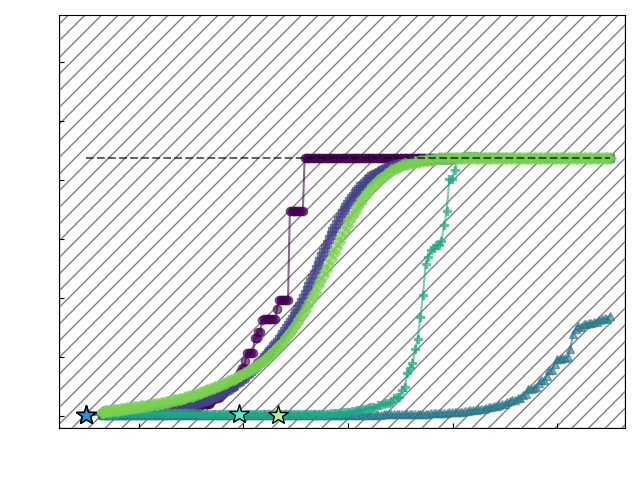

In [4]:
import bussilab
from bussilab import wham
import scipy
from scipy.optimize import minimize
import cudamat as cm
import numpy as np
import matplotlib.pyplot as plt
import re
import math
kBT=0.6 #kBT in kcal/mol
np.random.seed(1995)
%matplotlib notebook
eps=1e-30

fig, ax = plt.subplots()
obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
regularization_list=['L1','L2','KishSize','RelativeKishSize','RelativeEntropy']
marker_list=['o','s','^','P','D']
cmap = plt.cm.get_cmap('viridis')

chi2_error_collector=[]
for r,regularization in enumerate(regularization_list):
    c=cmap(r/len(regularization_list))
    m=marker_list[r]
    alpha_list=[]
    training_chi2_list=[]
    cv_chi2_list=[]
    ref_chi2_list=[]
    Training_ref_chi2_list=[]
    CV_ref_chi2_list=[]
    with open('./data_produced/CVTrajectory_indivComp_errors_%s_%s_00to100000000.dat' % (regularization,eps), "r") as f:
            for line in f:
                nums=line.split()
                alpha_list.append(float(nums[0]))
                training_chi2_list.append(float(nums[1])) 
                cv_chi2_list.append(float(nums[3])) 
                ref_chi2_list.append(float(nums[5])) 
                Training_ref_chi2_list.append(float(nums[6])) 
                CV_ref_chi2_list.append(float(nums[7])) 
    
    chi2_error_collector.append(training_chi2_list)
    for index,a in enumerate(alpha_list):
        alpha_list[index]=a+0.001
    plt.plot(alpha_list,training_chi2_list, color=c, marker=m, alpha=0.6, label='%s' % (regularization))

ax.set_xlim(0.0003,19500000)

plt.plot(alpha_list,ref_chi2_list, '--',color='black', alpha=0.6, label='reference FF')
plt.ylabel('$ \chi ^2 $', fontsize=22)
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tick_params(axis="x",direction="in")
plt.xticks(color='w',fontsize=22)
plt.ylim(-1,34)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
regularization_list=['L1','L2','KishSize','RelativeKishSize','RelativeEntropy']
short_reg=['L1','L2','K','$K_{rel}$','$S_{rel}$']
marker_list=['o','s','^','P','D']
scmap = plt.cm.get_cmap('rainbow_r')
cmap = plt.cm.get_cmap('viridis')

for r,regularization in enumerate(regularization_list):
    c=cmap(r/len(regularization_list))
    sc=scmap(r/len(regularization_list))
    m=marker_list[r]
    alpha_list=[]
    training_chi2_list=[]
    cv_chi2_list=[]
    ref_chi2_list=[]
    Training_ref_chi2_list=[]
    CV_ref_chi2_list=[]
    with open('./data_produced/CVTrajectory_indivComp_errors_%s_%s_00to100000000.dat' % (regularization,eps), "r") as f:    
            for line in f:
                nums=line.split()
                alpha_list.append(float(nums[0]))
                training_chi2_list.append(float(nums[1])) 
                cv_chi2_list.append(float(nums[3])) 
                ref_chi2_list.append(float(nums[5])) 
                Training_ref_chi2_list.append(float(nums[6])) 
                CV_ref_chi2_list.append(float(nums[7])) 
    #print(alpha_list[cv_chi2_list.index(min(cv_chi2_list))])
    for index,a in enumerate(alpha_list):
        alpha_list[index]=a+0.001

    plt.plot(alpha_list,cv_chi2_list, color=c, marker=m,alpha=0.6, label='%s' % (short_reg[r]))
    plt.plot(alpha_list[cv_chi2_list.index(min(cv_chi2_list))],min(cv_chi2_list), color='black', marker='*', markersize=15, markerfacecolor=sc, markeredgecolor='black', zorder=20)
    
rec2 = plt.Rectangle((0.0003,-1),19500000,2000,facecolor="white", 
                     edgecolor="grey", hatch=r"//")
ax.add_patch(rec2)   
ax.set_ylim(-1,34)
ax.set_xlim(0.0003,19500000)
    
plt.plot(alpha_list,CV_ref_chi2_list, '--',color='black', alpha=0.6, label='reference FF') 
plt.xscale('log')
plt.xticks(fontsize=22)
plt.xticks(color='w',fontsize=22)
plt.yticks(color='w',fontsize=22)
plt.tick_params(axis="x",direction="in")
plt.tick_params(axis="y",direction="in")
plt.ylim(-1,34)
plt.tight_layout()
plt.show()